In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

## 1. load data

In [3]:
df = pd.read_csv('Murakami25_example.csv')
df.head()

,ztfname,zHD,zHDERR,mB,mBERR,x1,x1ERR,c,cERR,cov_mB_x1,...,host_logmass_err,host_logmass_local,host_logmass_local_err,host_color,host_color_err,host_color_local,host_color_local_err,HR_tripp,HR_tripp_err,HR_tripp_err_nosigint
0,ZTF18aabtiph,0.035920,0.000014,16.727679,0.155464,-2.373090,0.178315,-0.292570,0.097267,1.708170e-02,...,0.126823,10.123,0.036,1.261697,0.018439,1.275697,0.018439,0.366558,0.212501,0.127502
1,ZTF18aagrtxs,0.029709,0.000012,16.232706,0.033116,-0.711071,0.037107,-0.148560,0.028009,-5.231956e-07,...,0.154674,9.062,0.057,1.268697,0.018439,1.272697,0.021260,0.072031,0.179909,0.058885
2,ZTF18aagstdc,0.040367,0.003890,16.558735,0.032854,-0.047931,0.049832,-0.097615,0.027518,3.410154e-05,...,0.153154,7.874,0.481,1.082697,0.162111,1.249697,1.128405,-0.263420,0.179627,0.058015
3,ZTF18aahfbqp,0.041145,0.000013,16.876278,0.060113,-1.969450,0.278768,-0.112340,0.056368,8.967122e-03,...,0.136561,10.543,0.118,1.311697,0.018439,1.295697,0.017692,-0.208889,0.215822,0.132962
4,ZTF18aahfgsk,0.053768,0.000013,17.560338,0.041241,0.316294,0.108006,-0.108032,0.031680,1.941579e-03,...,0.122642,8.722,0.031,1.188697,0.018385,1.097697,0.029732,0.180388,0.180825,0.061625


## 1. prepare the data map (2D rolling median)

In [4]:
from host2d import Host2DFitter

In [5]:
host2d = Host2DFitter(
    color           = df['c'].values, 
    color_err       = df['cERR'].values, 
    tracer          = df['host_logmass'].values, 
    tracer_err      = df['host_logmass_err'].values,
    HR              = df['HR_tripp'].values,
    HR_err          = df['HR_tripp_err'].values,
    HR_err_nosigint = df['HR_tripp_err_nosigint'].values
)

In [6]:
data_map,data_map_Ndata,domain_func = host2d.get_data_map(
    c_grid = np.linspace(-0.165, 0.3, 25), # SALT2 color grid
    tracer_grid = np.linspace(8, 11.4, 25), # global mass grid
    c_window = 0.05,
    tracer_window = 0.3,
    N_bootstrap = 3000,
    min_Ndata_required = 4
)

  0%|          | 0/3000 [00:00<?, ?it/s]

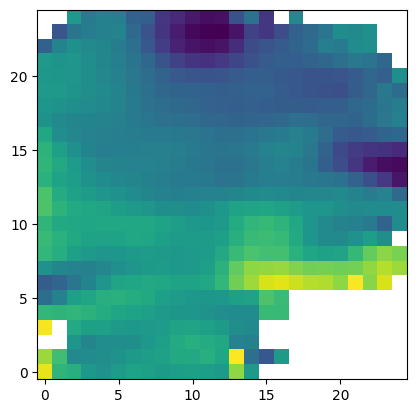

In [7]:
plt.imshow(data_map.T,origin='lower',aspect='equal',cmap='viridis')

## 2. fit spline (the Host2D model)

In [8]:
### fitting
host2d.prep_splint_fit(Nx=1,Ny=1,kx=1,ky=1) # set number of knots (Nx,Ny) and polynomial order (kx,ky)
spline = host2d.fit() # returns scipy.interpolate._fitpack2.LSQBivariateSpline object

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 807.1233359934822
             x: [ 4.373e-02  1.001e+01]
           nit: 109
          nfev: 203
 final_simplex: (array([[ 4.373e-02,  1.001e+01],
                       [ 4.373e-02,  1.001e+01],
                       [ 4.373e-02,  1.001e+01]]), array([ 8.071e+02,  8.071e+02,  8.071e+02]))


In [9]:
### results
# you can directly evaluate the model using the returned spline object:
# HR_model = spline(0.1,9.5,grid=False) model value at c=0.1, logmass=9.5

# or use the built-in function to get the model value at the data points:
HR_corr,HR_model,in_domain = host2d.evaluate() # uses the stored color and tracer values by default

# alternatively, you can provide any arrays of SN color and host tracer values:
# HR_corr,HR_model,in_domain = host2d.evaluate(color=color_arr,tracer=tracer_arr,HR=HR_arr)

# print the chi-square
chi2_original = np.sum(host2d.HR**2/host2d.HR_err**2)
chi2 = np.sum(HR_corr**2/host2d.HR_err**2)
print(f'Original chi2: {chi2_original:.2f}')
print(f'New chi2:      {chi2:.2f}')

Original chi2: 901.25
New chi2:      807.12


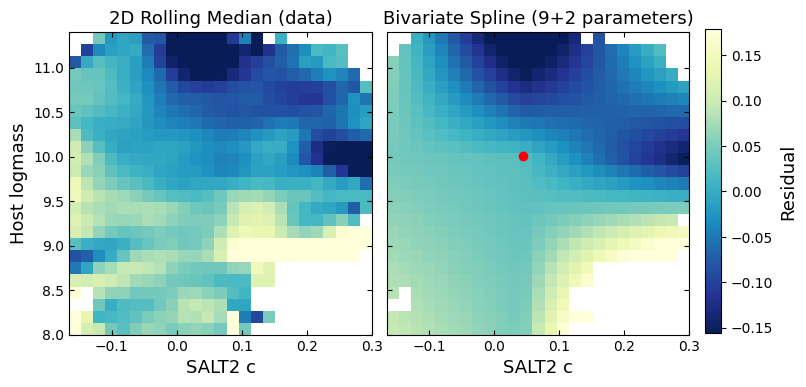

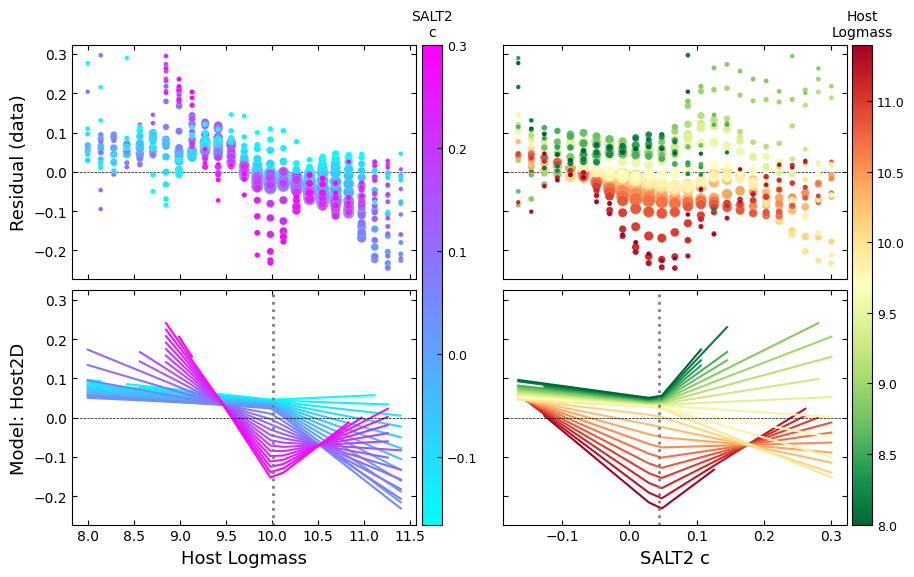

In [10]:
# plot the spline fit
host2d.plot_2D(ylabel='Host logmass')
host2d.plot_trace(tracer_label='Host\nLogmass')

## if usage is unclear:

please see docstrings.

In [11]:
host2d.get_data_map?

Signature:
host2d.get_data_map(
    c_grid,
    tracer_grid,
    c_window,
    tracer_window,
    N_bootstrap=1000,
    min_Ndata_required=4,
)
Docstring:
Call rolling_median_2D_MC to get the data map. 
Performs Monte Carlo and 2D rolling binning to get the 2D map of Hubble residuals over given grid values.

Inputs:
    c_grid (np.array): grid of color values at which to evaluate the spline
    tracer_grid (np.array): grid of tracer values at which to evaluate the spline
    c_window (float): window size for color
    tracer_window (float): window size for tracer
    N_bootstrap (int): number of bootstrap realizations (default: 1000)
    min_Ndata_required (int): minimum number of data points required in each bin (default: 4)
    
Outputs:
    HR_binned (np.array): the 2D HR values
    HR_binned_Ndata (np.array): number of data points in each bin
    domain_func (function): function that returns true if a point is in the domain of the map
File:      ~/Dropbox/projects/Host2D/host2d.py


In [12]:
host2d.fit?

Signature:
host2d.fit(
    init_knots=None,
    method='Nelder-Mead',
    options={'fatol': 1e-08, 'xatol': 1e-10, 'maxfev': 10000.0},
    print_res=True,
)
Docstring:
Fit the spline to the data and optimize the knot location to minimize the residual.

Inputs:
    init_knots: initial guess for the knot positions (default: self.init_knots)
    method: optimization method (default: 'Nelder-Mead')
    options: optimization options (default: {'fatol':1e-8,'xatol':1e-10,'maxfev':1e4})
    print_res: if True, print the optimization results (default: True)
    
Outputs:
    self.spline: the best-fit spline (scipy.interpolate._fitpack2.LSQBivariateSpline object)
File:      ~/Dropbox/projects/Host2D/host2d.py
Type:      method

In [13]:
host2d.evaluate?

Signature: host2d.evaluate(color=None, tracer=None, HR=None)
Docstring:
evaluate the spline at the given c and tracer values.

Inputs:
    color: array of color values (default: self.color)
    tracer: array of tracer values (default: self.tracer)
    HR: array of HR values (default: self.HR)
    
Ouputs:
    HR_corr: array of corrected HR values (HR_data - HR_model)
    HR_model: array of model HR values
    in_domain: boolean array indicating if the points are in the domain of the spline
File:      ~/Dropbox/projects/Host2D/host2d.py
Type:      method